## 📅 Day 7: Capstone Project

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import pandas as pd
import numpy as np

In [5]:
ds = load_dataset("sms_spam")
df = pd.DataFrame(ds["train"])
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
df["label"].value_counts(normalize=True)

label
0    0.865985
1    0.134015
Name: proportion, dtype: float64

In [7]:
# 1. Preprocess with pandas → TensorDataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df['sms'],df['label'],test_size=0.2,random_state=42, stratify=df['label'])
print(f"Training size = {len(y_train)}, Evaluate size = {len(y_val)}")

Training size = 4459, Evaluate size = 1115


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=5000)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_val)
Xtr[:5]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 91 stored elements and shape (5, 5000)>

In [9]:
type(Xtr), type(Xtr.toarray())

(scipy.sparse._csr.csr_matrix, numpy.ndarray)

In [14]:
X_tr_t = torch.tensor(Xtr.toarray(), dtype=torch.float32)
X_te_t = torch.tensor(Xte.toarray(), dtype=torch.float32)
y_tr_t = torch.tensor(y_train.values, dtype=torch.float32)
y_te_t = torch.tensor(y_val.values, dtype=torch.float32)

In [17]:
X_tr_t.shape, y_tr_t.shape

(torch.Size([4459, 5000]), torch.Size([4459]))

In [20]:
ds_train = TensorDataset(X_tr_t, y_tr_t.unsqueeze(dim=1))
ds_val = TensorDataset(X_te_t, y_te_t.unsqueeze(dim=1))

In [21]:
# 2. Create DataLoader
train_loader = DataLoader(ds_train, batch_size=256)
val_loader = DataLoader(ds_val, batch_size=512)

In [35]:
# 3. Define Model
class TextMLP(nn.Module):
    def __init__(self, in_dim=500, out_dim=1, hidden_dim=256, dropout=0.0, norm=False):
        super().__init__()
        self.norm = norm
        self.norm0 = nn.LayerNorm(in_dim)
        self.fc0 = nn.Linear(in_dim, hidden_dim)
        self.act= nn.ReLU()
        self.drop = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        if self.norm:
            x = self.norm0(x)
        h = self.fc0(x)
        h = self.act(h)
        h = self.drop(h)
        y = self.fc1(h)
        return y

In [37]:
def train_epoch(dataloader, model, criterion, optimizer):
    model.train()
    total_sample, total_loss, total_correct = 0, 0.0, 0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        y = y.view(-1)
        logit = model(X).squeeze(1)
        loss = criterion(logit, y)
        sample = y.shape[0]
        total_loss += loss.item()*sample
        total_sample += sample
        prob = torch.sigmoid(logit)
        total_correct += ((prob>=0.5).float()==y).sum().item()
        loss.backward()
        optimizer.step()
        if batch % 100==0:
            loss, current = loss.item(), batch * dataloader.batch_size + sample
            print(f"Train Loss: {loss:>6f} [{current}/{len(dataloader.dataset)}]")
    return total_loss/total_sample, total_correct/total_sample

In [41]:
def eval_epoch(dataloader, model, criterion):
    model.eval()
    total_sample, total_loss, total_correct = 0, 0.0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            y = y.view(-1)
            logit = model(X).squeeze(1)
            loss = criterion(logit, y)
            sample = y.shape[0]
            total_loss += loss.item()*sample
            total_sample += sample
            prob = torch.sigmoid(logit)
            total_correct += ((prob>=0.5).float()==y).sum().item()
            
    test_loss = total_loss/total_sample 
    test_acc = total_correct/total_sample    
    print(f"Loss: {test_loss:>6f} | Accuracy: {test_acc:>5f}")
    return test_loss, test_acc

In [31]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    history: dict containing lists per epoch
      e.g. {"train_loss": [...], "val_loss": [...], "train_acc": [...], "val_acc": [...]}
    """

    epochs = range(1, len(history["train_loss"]) + 1)

    # --- Loss plot ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Accuracy plot (optional) ---
    if "train_acc" in history and "val_acc" in history:
        plt.figure(figsize=(6,4))
        plt.plot(epochs, history["train_acc"], label="Train Acc")
        plt.plot(epochs, history["val_acc"], label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training vs Validation Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

In [61]:
# 4. Train with BCEWithLogitsLoss
def trainBCEWithLogitsLoss(X_tr_t, X_te_t, y_tr_t, y_te_t, epochs= 50, lr=1e-3, optimizer_fn=optim.Adam, weight_decay=1e-3, hidden_dim=256, dropout=0.0, norm=False, patience=5, delta=1e-3):
    ds_train = TensorDataset(X_tr_t, y_tr_t.unsqueeze(dim=1))
    ds_val = TensorDataset(X_te_t, y_te_t.unsqueeze(dim=1))
    train_loader = DataLoader(ds_train, batch_size=256)
    val_loader = DataLoader(ds_val, batch_size=512)
    model = TextMLP(in_dim=X_tr_t.shape[1], out_dim=1, hidden_dim=hidden_dim, dropout=dropout, norm=norm)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optimizer_fn(model.parameters(),lr=lr, weight_decay=weight_decay)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_loss = None
    counter = 0
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer)
        val_loss, val_acc     = eval_epoch(val_loader, model, criterion)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch}")
        if not best_loss:
            best_loss = val_loss
        else:
            if best_loss>val_loss:
                if best_loss-val_loss<delta:
                    counter +=1
                    print(f"Current early stop counter = {counter}")
                if counter>patience:
                    break
                best_loss = val_loss
            else:
                counter = 0
    
    plot_training_curves(history)
    return model, history


Train Loss: 0.672010 [256/4459]
Loss: 0.531161 | Accuracy: 0.871749
Epoch 0
Train Loss: 0.534068 [256/4459]
Loss: 0.367099 | Accuracy: 0.901345
Epoch 1
Train Loss: 0.375459 [256/4459]
Loss: 0.258034 | Accuracy: 0.930942
Epoch 2
Train Loss: 0.269529 [256/4459]
Loss: 0.198044 | Accuracy: 0.952466
Epoch 3
Train Loss: 0.210667 [256/4459]
Loss: 0.162157 | Accuracy: 0.965022
Epoch 4
Train Loss: 0.173997 [256/4459]
Loss: 0.138873 | Accuracy: 0.973991
Epoch 5
Train Loss: 0.149346 [256/4459]
Loss: 0.123006 | Accuracy: 0.977578
Epoch 6
Train Loss: 0.132098 [256/4459]
Loss: 0.111740 | Accuracy: 0.977578
Epoch 7
Train Loss: 0.119432 [256/4459]
Loss: 0.103417 | Accuracy: 0.979372
Epoch 8
Train Loss: 0.109736 [256/4459]
Loss: 0.097003 | Accuracy: 0.981166
Epoch 9
Train Loss: 0.101981 [256/4459]
Loss: 0.091928 | Accuracy: 0.982063
Epoch 10
Train Loss: 0.095596 [256/4459]
Loss: 0.087799 | Accuracy: 0.982063
Epoch 11
Train Loss: 0.090220 [256/4459]
Loss: 0.084327 | Accuracy: 0.982960
Epoch 12
Train Los

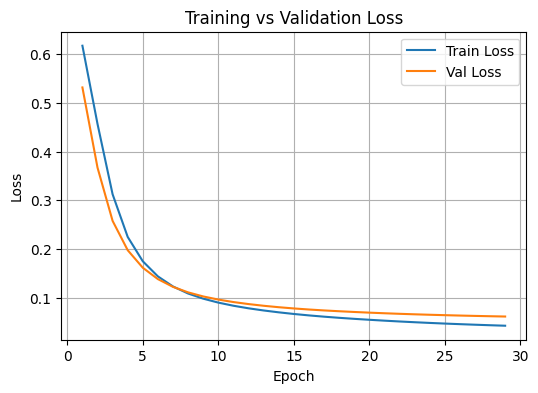

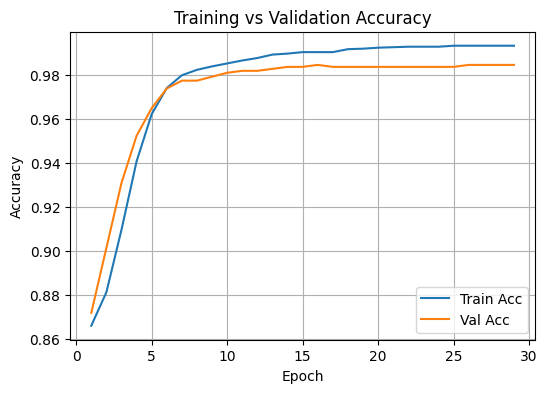

In [62]:
# 5. Track loss/accuracy over epochs
default_mlp, _ = trainBCEWithLogitsLoss(X_tr_t, X_te_t, y_tr_t, y_te_t)

Train Loss: 0.703172 [256/4459]
Loss: 0.212495 | Accuracy: 0.947982
Epoch 0
Train Loss: 0.232367 [256/4459]
Loss: 0.150408 | Accuracy: 0.973094
Epoch 1
Train Loss: 0.167463 [256/4459]
Loss: 0.123438 | Accuracy: 0.977578
Epoch 2
Train Loss: 0.137858 [256/4459]
Loss: 0.108375 | Accuracy: 0.980269
Epoch 3
Train Loss: 0.120573 [256/4459]
Loss: 0.098615 | Accuracy: 0.982063
Epoch 4
Train Loss: 0.108887 [256/4459]
Loss: 0.091677 | Accuracy: 0.982960
Epoch 5
Train Loss: 0.100247 [256/4459]
Loss: 0.086409 | Accuracy: 0.982960
Epoch 6
Train Loss: 0.093436 [256/4459]
Loss: 0.082270 | Accuracy: 0.984753
Epoch 7
Train Loss: 0.087816 [256/4459]
Loss: 0.078886 | Accuracy: 0.984753
Epoch 8
Train Loss: 0.083066 [256/4459]
Loss: 0.076068 | Accuracy: 0.983857
Epoch 9
Train Loss: 0.078942 [256/4459]
Loss: 0.073564 | Accuracy: 0.983857
Epoch 10
Train Loss: 0.075191 [256/4459]
Loss: 0.071346 | Accuracy: 0.984753
Epoch 11
Train Loss: 0.071803 [256/4459]
Loss: 0.069408 | Accuracy: 0.984753
Epoch 12
Train Los

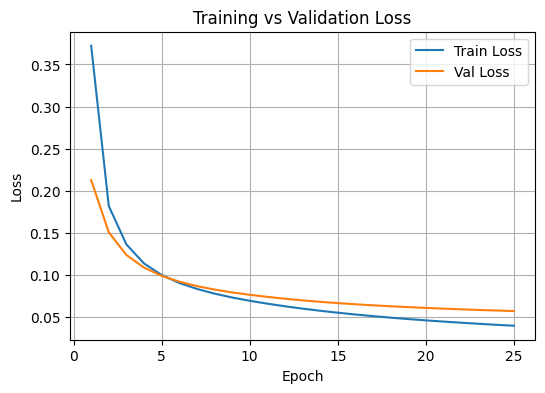

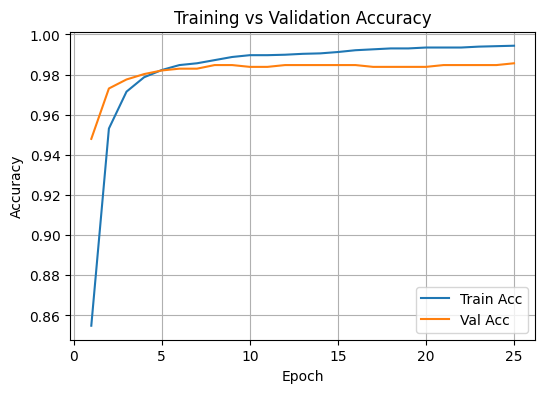

In [63]:
# 🧠 Bonus:
# - Try different optimizers (SGD, RMSprop, Adam)
_, _ = trainBCEWithLogitsLoss(X_tr_t, X_te_t, y_tr_t, y_te_t, optimizer_fn=optim.RMSprop)

Train Loss: 0.677072 [256/4459]
Loss: 0.213209 | Accuracy: 0.947085
Epoch 0
Train Loss: 0.233128 [256/4459]
Loss: 0.151101 | Accuracy: 0.972197
Epoch 1
Train Loss: 0.170809 [256/4459]
Loss: 0.124077 | Accuracy: 0.977578
Epoch 2
Train Loss: 0.140428 [256/4459]
Loss: 0.108897 | Accuracy: 0.979372
Epoch 3
Train Loss: 0.121905 [256/4459]
Loss: 0.098855 | Accuracy: 0.982063
Epoch 4
Train Loss: 0.109054 [256/4459]
Loss: 0.091824 | Accuracy: 0.982063
Epoch 5
Train Loss: 0.098672 [256/4459]
Loss: 0.086498 | Accuracy: 0.982960
Epoch 6
Train Loss: 0.093470 [256/4459]
Loss: 0.082157 | Accuracy: 0.984753
Epoch 7
Train Loss: 0.090296 [256/4459]
Loss: 0.078741 | Accuracy: 0.984753
Epoch 8
Train Loss: 0.081568 [256/4459]
Loss: 0.075883 | Accuracy: 0.983857
Epoch 9
Train Loss: 0.078393 [256/4459]
Loss: 0.073441 | Accuracy: 0.983857
Epoch 10
Train Loss: 0.075169 [256/4459]
Loss: 0.070951 | Accuracy: 0.983857
Epoch 11
Train Loss: 0.071315 [256/4459]
Loss: 0.069117 | Accuracy: 0.984753
Epoch 12
Train Los

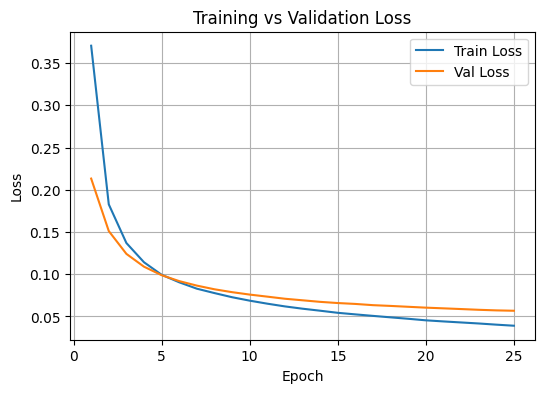

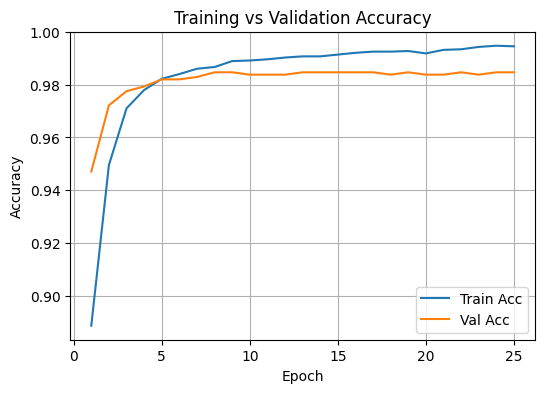

In [65]:
_, _ = trainBCEWithLogitsLoss(X_tr_t, X_te_t, y_tr_t, y_te_t, optimizer_fn=optim.RMSprop, dropout=0.2)

In [46]:
# Use Sentence-BERT embeddings instead of TFIDF
from sentence_transformers import SentenceTransformer
st = SentenceTransformer('sentence-transformers/stsb-bert-large')
embeddings = st.encode(X_train.iloc[0])

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [47]:
print(X_train.iloc[0]), print(embeddings)

Ok i am on the way to home hi hi

[-0.32000783  0.5716094  -0.00396993 ...  0.04169896 -0.17939849
 -0.05508134]


(None, None)

In [48]:
texts_train = X_train.tolist()
texts_val   = X_val.tolist()
emb_tr = st.encode(
    texts_train,
    batch_size=64,
    convert_to_numpy=True,
    show_progress_bar=True,
    normalize_embeddings=False  # set True if you’ll use cosine similarity; for MLP leave False or test both
)
emb_val = st.encode(
    texts_val,
    batch_size=64,
    convert_to_numpy=True,
    show_progress_bar=True,
    normalize_embeddings=False
)

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [49]:
type(emb_tr)

numpy.ndarray

In [50]:
X_tr_t2 = torch.tensor(emb_tr, dtype=torch.float32)
X_te_t2 = torch.tensor(emb_val, dtype=torch.float32)

Train Loss: 0.679085 [256/4459]
Loss: 0.072440 | Accuracy: 0.976682
Epoch 0
Train Loss: 0.099653 [256/4459]
Loss: 0.047912 | Accuracy: 0.983857
Epoch 1
Train Loss: 0.054512 [256/4459]
Loss: 0.038287 | Accuracy: 0.988341
Epoch 2
Train Loss: 0.034916 [256/4459]
Loss: 0.034151 | Accuracy: 0.990135
Epoch 3
Train Loss: 0.027612 [256/4459]
Loss: 0.033191 | Accuracy: 0.991031
Epoch 4
Current early stop counter = 1
Train Loss: 0.021496 [256/4459]
Loss: 0.031979 | Accuracy: 0.991031
Epoch 5
Train Loss: 0.014547 [256/4459]
Loss: 0.030911 | Accuracy: 0.991031
Epoch 6
Train Loss: 0.014414 [256/4459]
Loss: 0.030325 | Accuracy: 0.991031
Epoch 7
Current early stop counter = 2
Train Loss: 0.010883 [256/4459]
Loss: 0.030641 | Accuracy: 0.991928
Epoch 8
Train Loss: 0.010378 [256/4459]
Loss: 0.030979 | Accuracy: 0.992825
Epoch 9
Train Loss: 0.008969 [256/4459]
Loss: 0.028881 | Accuracy: 0.991928
Epoch 10
Train Loss: 0.007893 [256/4459]
Loss: 0.030217 | Accuracy: 0.991928
Epoch 11
Train Loss: 0.008680 [25

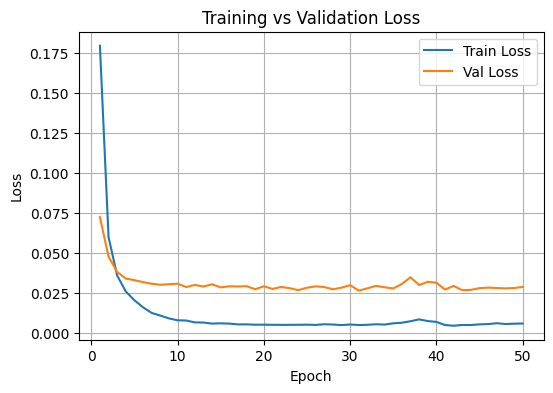

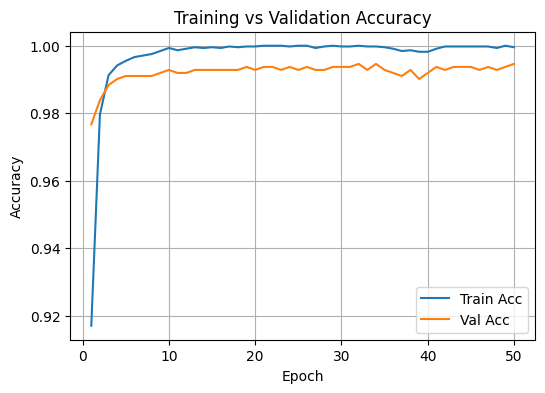

In [67]:
default_st_mlp, _ = trainBCEWithLogitsLoss(X_tr_t2, X_te_t2, y_tr_t, y_te_t, dropout=0.2, norm=True)

Train Loss: 0.781939 [256/4459]
Loss: 0.079910 | Accuracy: 0.970404
Epoch 0
Train Loss: 0.095738 [256/4459]
Loss: 0.052631 | Accuracy: 0.981166
Epoch 1
Train Loss: 0.056266 [256/4459]
Loss: 0.040180 | Accuracy: 0.988341
Epoch 2
Train Loss: 0.039041 [256/4459]
Loss: 0.035455 | Accuracy: 0.989238
Epoch 3
Train Loss: 0.031436 [256/4459]
Loss: 0.033487 | Accuracy: 0.991031
Epoch 4
Train Loss: 0.019429 [256/4459]
Loss: 0.032799 | Accuracy: 0.991031
Epoch 5
Train Loss: 0.012362 [256/4459]
Loss: 0.031948 | Accuracy: 0.991031
Epoch 6
Train Loss: 0.009989 [256/4459]
Loss: 0.032234 | Accuracy: 0.991928
Epoch 7
Train Loss: 0.007809 [256/4459]
Loss: 0.031911 | Accuracy: 0.991928
Epoch 8
Train Loss: 0.004822 [256/4459]
Loss: 0.032343 | Accuracy: 0.991031
Epoch 9
Train Loss: 0.004830 [256/4459]
Loss: 0.033496 | Accuracy: 0.991031
Epoch 10
Train Loss: 0.004470 [256/4459]
Loss: 0.034079 | Accuracy: 0.990135
Epoch 11
Train Loss: 0.002852 [256/4459]
Loss: 0.032474 | Accuracy: 0.992825
Epoch 12
Train Los

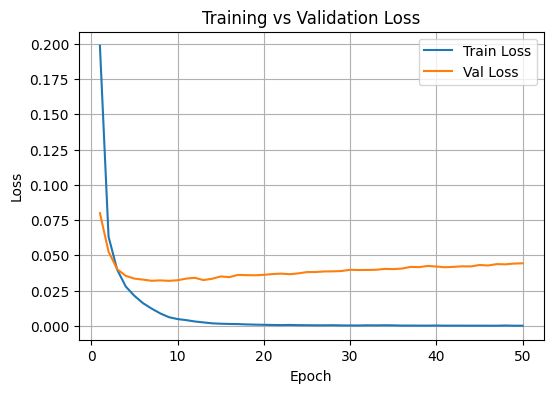

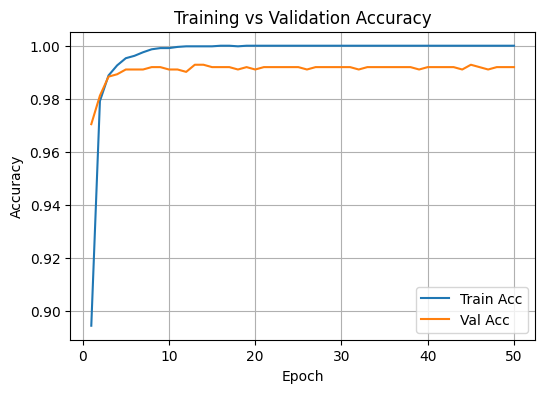

In [52]:
_, _ = trainBCEWithLogitsLoss(X_tr_t2, X_te_t2, y_tr_t, y_te_t, optimizer_fn=optim.AdamW, dropout=0.2, norm=True)

Train Loss: 0.796576 [256/4459]
Loss: 0.130455 | Accuracy: 0.962332
Epoch 0
Train Loss: 0.144711 [256/4459]
Loss: 0.084881 | Accuracy: 0.973094
Epoch 1
Train Loss: 0.101909 [256/4459]
Loss: 0.064472 | Accuracy: 0.979372
Epoch 2
Train Loss: 0.077016 [256/4459]
Loss: 0.053372 | Accuracy: 0.981166
Epoch 3
Train Loss: 0.062611 [256/4459]
Loss: 0.046857 | Accuracy: 0.983857
Epoch 4
Train Loss: 0.055169 [256/4459]
Loss: 0.042138 | Accuracy: 0.987444
Epoch 5
Train Loss: 0.041499 [256/4459]
Loss: 0.038927 | Accuracy: 0.988341
Epoch 6
Train Loss: 0.038295 [256/4459]
Loss: 0.036455 | Accuracy: 0.988341
Epoch 7
Train Loss: 0.032505 [256/4459]
Loss: 0.034435 | Accuracy: 0.990135
Epoch 8
Train Loss: 0.029969 [256/4459]
Loss: 0.032977 | Accuracy: 0.990135
Epoch 9
Train Loss: 0.028806 [256/4459]
Loss: 0.031866 | Accuracy: 0.990135
Epoch 10
Train Loss: 0.019428 [256/4459]
Loss: 0.030765 | Accuracy: 0.990135
Epoch 11
Train Loss: 0.019891 [256/4459]
Loss: 0.030247 | Accuracy: 0.990135
Epoch 12
Current e

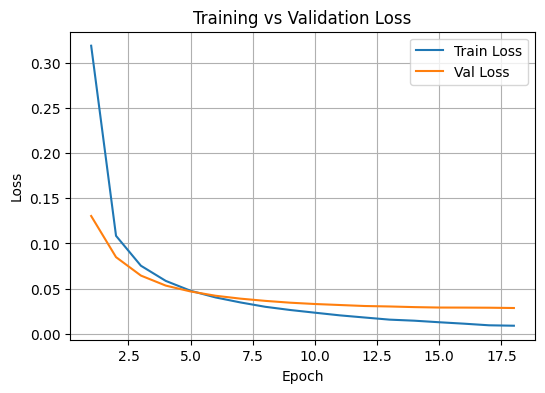

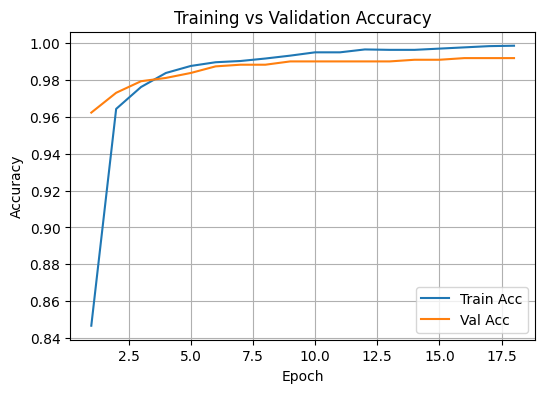

In [69]:
best_sofar, _ = trainBCEWithLogitsLoss(X_tr_t2, X_te_t2, y_tr_t, y_te_t, lr=3e-4, optimizer_fn=optim.AdamW, dropout=0.2, norm=True)

In [70]:
# 6. Evaluate on held-out test set
df_test = pd.DataFrame(ds["train"])
X_test, y_test = df_test['sms'],df_test['label']

# tfidf
Xtest = tfidf.transform(X_test)
X_test_t = torch.tensor(Xtest.toarray(), dtype=torch.float32)

# sentence transformer
texts_test   = X_test.tolist()
emb_test = st.encode(
    texts_test,
    batch_size=64,
    convert_to_numpy=True,
    show_progress_bar=True,
    normalize_embeddings=False
)
X_test_t2 = torch.tensor(emb_test, dtype=torch.float32)

Batches:   0%|          | 0/88 [00:00<?, ?it/s]

In [71]:
y_test_t = torch.tensor(y_test.values, dtype=torch.float32)

In [72]:
def holdout_eval(X, y, model, criterion=nn.BCEWithLogitsLoss()):
    model.eval()
    with torch.no_grad():
        y = y.view(-1)
        logit = model(X).squeeze(1)
        loss = criterion(logit, y)
        total_sample = y.shape[0]
        total_loss = loss.item()
        prob = torch.sigmoid(logit)
        total_correct = ((prob>=0.5).float()==y).sum().item()
            
    test_loss = total_loss/total_sample 
    test_acc = total_correct/total_sample    
    print(f"Loss: {test_loss:>6f} | Accuracy: {test_acc:>5f}")
    return test_loss, test_acc

In [73]:
holdout_eval(X_test_t, y_test_t, default_mlp)

Loss: 0.000008 | Accuracy: 0.992644


(8.053041708524996e-06, 0.9926444205238608)

In [74]:
holdout_eval(X_test_t2, y_test_t, best_sofar)

Loss: 0.000002 | Accuracy: 0.997847


(2.0584394299175563e-06, 0.9978471474703983)

In [75]:
# - Plot decision boundary (2D toy dataset)
from sklearn.datasets import make_moons
X2d, y2d = make_moons(n_samples=1000, noise=0.2, random_state=42)  # X: (N,2), y: (N,)
Xt2d = torch.tensor(X2d, dtype=torch.float32)
yt2d = torch.tensor(y2d, dtype=torch.float32)

In [78]:
model2d = TextMLP(in_dim=2, hidden_dim=16)
opt2d = optim.Adam(model2d.parameters(), lr=1e-2)
crit2d = nn.BCEWithLogitsLoss()

In [80]:
for _ in range(200):
    opt2d.zero_grad(set_to_none=True)
    logits = model2d(Xt2d).squeeze(1)
    loss = crit2d(logits, yt2d)
    loss.backward()
    opt2d.step()

model2d.eval()
@torch.no_grad()
def predict_proba_fn(Xgrid):  # Xgrid: (M,2) np.array
    G = torch.tensor(Xgrid, dtype=torch.float32)
    logits = model2d(G)
    return torch.sigmoid(logits).numpy()  # (M,)

In [81]:
x_min, x_max = X2d[:,0].min() - 0.5, X2d[:,0].max() + 0.5
y_min, y_max = X2d[:,1].min() - 0.5, X2d[:,1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
grid = np.c_[xx.ravel(), yy.ravel()]      # (400*400, 2)
probs = predict_proba_fn(grid).reshape(xx.shape)

In [82]:
grid.shape

(160000, 2)

In [83]:
probs.shape

(400, 400)

Text(0, 0.5, 'x2')

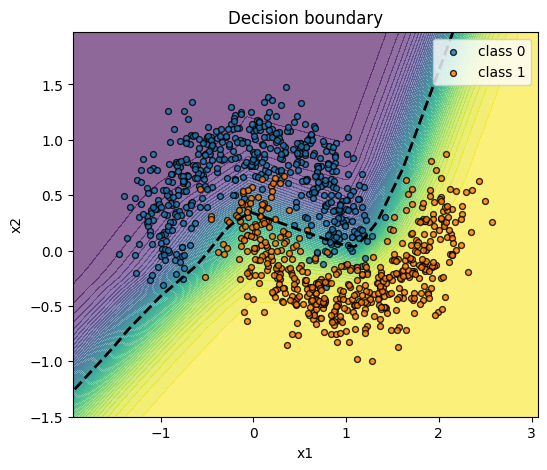

In [84]:
plt.figure(figsize=(6,5))
# Filled background by probability
cs = plt.contourf(xx, yy, probs, levels=50, alpha=0.6)
# Decision boundary at p=0.5
plt.contour(xx, yy, probs, levels=[0.5], linewidths=2, linestyles="--", colors="k")

# Scatter the points
plt.scatter(X2d[y2d==0,0], X2d[y2d==0,1], s=18, edgecolor="k", alpha=0.8, label="class 0")
plt.scatter(X2d[y2d==1,0], X2d[y2d==1,1], s=18, edgecolor="k", alpha=0.8, label="class 1")

plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
plt.legend(loc="best"); plt.title("Decision boundary")
plt.xlabel("x1"); plt.ylabel("x2")